# LightGBM

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
from scipy import stats
from numpy import median
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

# Reading training data from the local storage
filename = 'train.csv' 
df_train = pd.read_csv(filename)

# rename some columns
df_train.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'yr':'year',
                     'hum': 'humidity',
                     'cnt':'count'},inplace=True)

df_train = df_train.drop(['atemp', 'windspeed', 'casual', 'registered', 'holiday'], axis=1)

df_train = df_train[df_train.weather != 4]

X = df_train.drop(df_train[['count']], axis = 1)
y = df_train['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

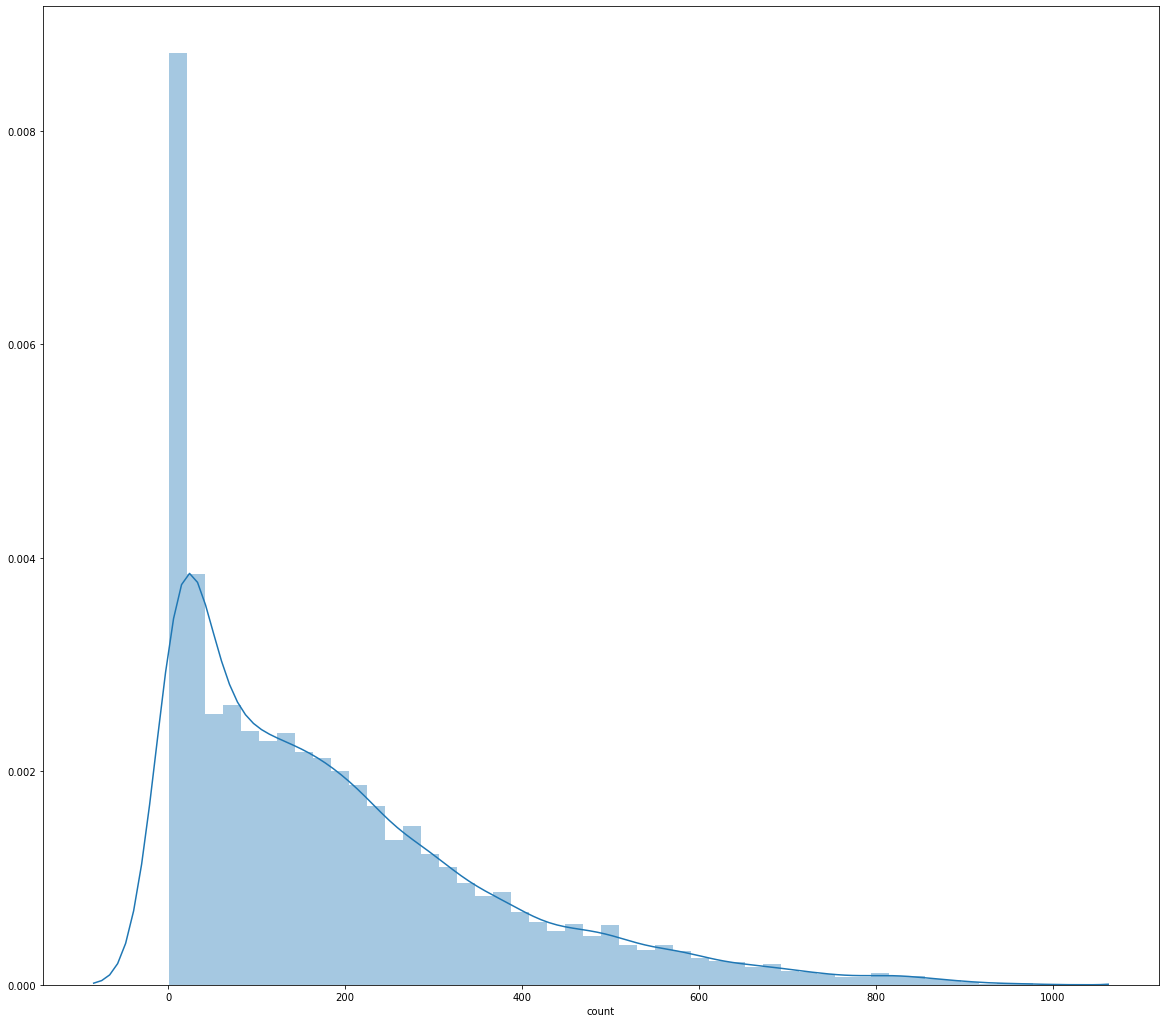

In [2]:
#plot count
fig,(ax1)= plt.subplots(nrows=1)
fig.set_size_inches(20, 18)
sn.distplot(df_train["count"],ax=ax1)

### Grid Search CV

In [4]:
estimator = lgb.LGBMRegressor(n_jobs = -1)

param_grid = {
    'objective' : ['tweedie'],
    'n_estimators': [690, 670],
    'tree_leaner': ['feature'],
    'tweedie_variance_power': [1.61, 1.59, 1.55, 1.5],
    'bagging_fraction': [0.2, 0.21, 0.19],
    'feature_fraction': [0.55, 0.57],
    'learning_rate': [0.1, 0.118, 0.2],
    'device' : ['gpu']
}

gridgbm = GridSearchCV(estimator, param_grid, cv=5, scoring = 'neg_mean_squared_log_error', n_jobs = -1)
gridgbm.fit(X_train, y_train, categorical_feature = ['season', 'month', 'workingday', 'weather'])

print('Best parameters found by grid search are:', gridgbm.best_params_)

y_pred = gridgbm.predict(X_test)
for i, y in enumerate(y_pred):
    if y_pred[i] < 0:
        y_pred[i] = 0
        
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))

C:\Users\Dimitrios\anaconda3\lib\site-packages\lightgbm\basic.py:1246: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['month', 'season', 'weather', 'workingday']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


LightGBMError: GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1

### Training

In [24]:
# train
gbm = lgb.LGBMRegressor(objective = 'tweedie', learning_rate = 0.1, tree_learner = 'feature', tweedie_variance_power = 1.55, bagging_fraction = 0.2, feature_fraction = 0.55, n_estimators = 690, n_jobs = -1)

gbm = gbm.fit(X, y, categorical_feature = ['season', 'month', 'workingday', 'weather'])

### Plots

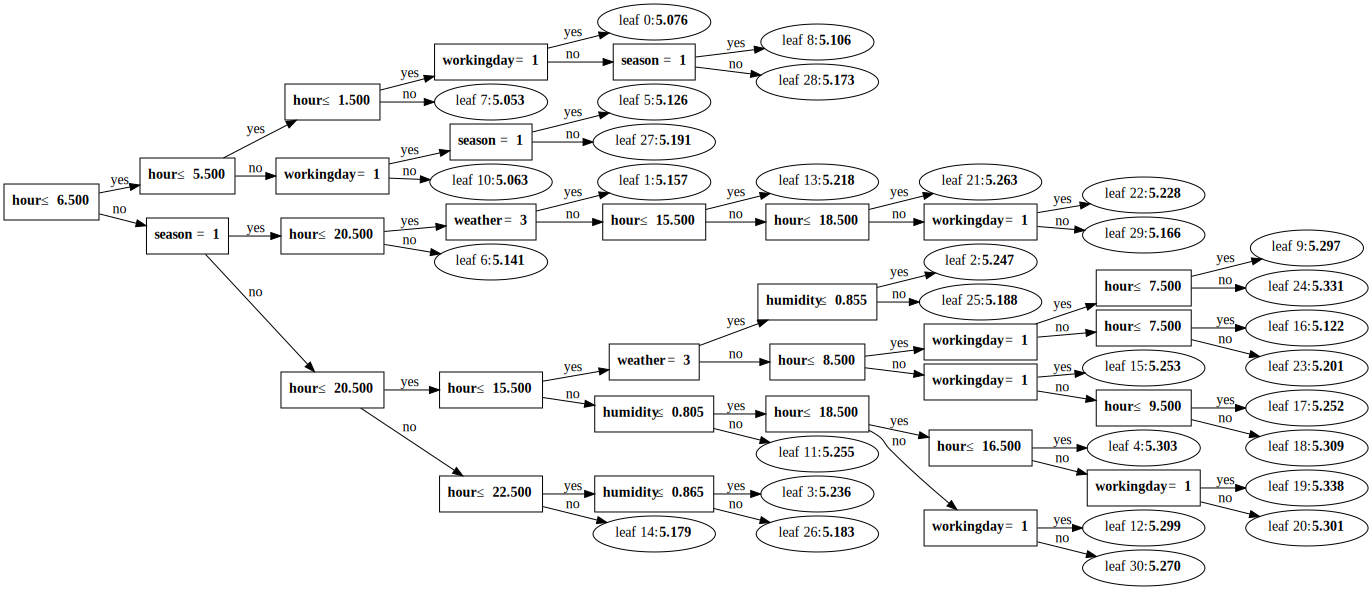

In [25]:
lgb.create_tree_digraph(gbm)

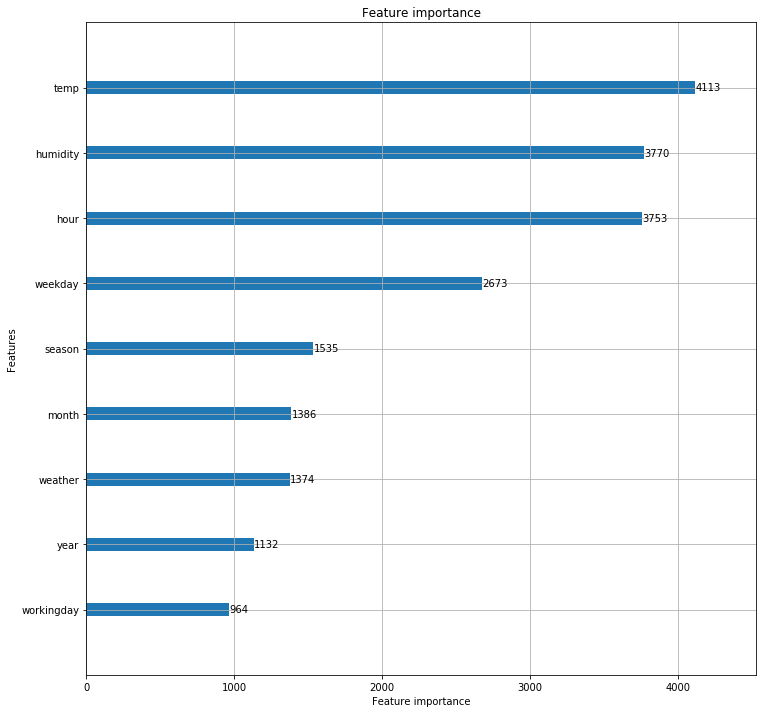

In [26]:
fig, ax = plt.subplots(figsize=(12, 12))
lgb.plot_importance(gbm, ax=ax)
plt.show()

### Predictions

In [16]:
filename = 'test.csv' 
df_test = pd.read_csv(filename)

df_test.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'yr':'year',
                     'hum': 'humidity',
                     'cnt':'count'},inplace=True)

df_test = df_test.drop(['atemp', 'windspeed', 'holiday'], axis=1)

y_pred = gbm.predict(df_test)

for i, y  in enumerate(y_pred):
    if y_pred[i] < 0:
        y_pred[i] = 0

submission = pd.DataFrame()
submission['Id'] = range(y_pred.shape[0])
submission['Predicted'] = y_pred
submission.to_csv("submission_gbm.csv", index=False)